In [1]:
import types
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
# PyTorch
import torch
import torchvision
import torchmetrics

In [2]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import losses
import utils

In [3]:
dataset_directory = '/cluster/tufts/hugheslab/eharve06/CIFAR-10'
n = 1000
tune = False
random_state = 1001
augmented_train_dataset, train_dataset, val_or_test_dataset = utils.get_cifar10_datasets(dataset_directory, n, tune, random_state)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
batch_size = 128
num_workers = 0
augmented_train_loader = torch.utils.data.DataLoader(augmented_train_dataset, batch_size=min(batch_size, len(augmented_train_dataset)), shuffle=True, num_workers=num_workers, drop_last=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=min(batch_size, len(train_dataset)), num_workers=num_workers)
val_or_test_loader = torch.utils.data.DataLoader(val_or_test_dataset, batch_size=batch_size, num_workers=num_workers)

In [5]:
num_classes = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

model = torchvision.models.resnet50()
model.fc = torch.nn.Linear(in_features=2048, out_features=num_classes, bias=True)
model.sigma_param = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1e-4, device=device))))
utils.add_variational_layers(model, model.sigma_param)
model.use_posterior = types.MethodType(utils.use_posterior, model)
model.to(device)

bb_loc = torch.load('/cluster/tufts/hugheslab/eharve06/resnet50_torchvision/resnet50_torchvision_mean.pt', map_location=torch.device('cpu')).to(device)
criterion = criterion = losses.L2KappaELBOLoss(bb_loc, 1.0, model.sigma_param)

cuda:0


In [6]:
good_model_with_kappa = []
bad_model_with_kappa = []
good_model_without_kappa = []
bad_model_without_kappa = []

checkpoint = torch.load('/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_CIFAR-10_VI/l2-sp_kappa=23528.522_lr_0=0.001_n=1000_random_state=1001.pt', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)
model.to(device)

model.use_posterior(True)
num_samples = 10
sample_metrics = [utils.evaluate(model, criterion, val_or_test_loader, num_classes=num_classes) for _ in range(num_samples)]
params = utils.flatten_params(model)
bb_loc_diff_norm = ((bb_loc - params[:len(bb_loc)])**2).sum()
clf_loc_diff_norm = (params[len(bb_loc):]**2).sum()
for lambd in np.logspace(-9, 3, 1000):
    lambda_star = torch.tensor(lambd)
    tau_star = torch.tensor(lambd)
    bb_term1 = (torch.nn.functional.softplus(model.sigma_param)**2/lambda_star) * len(params[:len(bb_loc)])
    bb_term2 = (1/lambda_star) * bb_loc_diff_norm
    bb_term3 = (len(params[:len(bb_loc)]) * torch.log(lambda_star)) - (len(params[:len(bb_loc)]) * torch.log(torch.nn.functional.softplus(model.sigma_param)**2))
    bb_kl = (1/2) * (bb_term1 + bb_term2 - len(params[:len(bb_loc)]) + bb_term3)
    clf_term1 = (torch.nn.functional.softplus(model.sigma_param)**2/tau_star) * len(params[len(bb_loc):])
    clf_term2 = (1/tau_star) * clf_loc_diff_norm
    clf_term3 = (len(params[len(bb_loc):]) * torch.log(tau_star)) - (len(params[len(bb_loc):]) * torch.log(torch.nn.functional.softplus(model.sigma_param)**2))
    clf_kl = (1/2) * (clf_term1 + clf_term2 - len(params[len(bb_loc):]) + clf_term3)
    good_model_with_kappa.append(sum(len(params) * metrics['nll'] + bb_kl + clf_kl for metrics in sample_metrics).item() / num_samples)
    good_model_without_kappa.append(sum(n * metrics['nll'] + bb_kl + clf_kl for metrics in sample_metrics).item() / num_samples)
    
checkpoint = torch.load('/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_CIFAR-10_VI/l2-sp_kappa=1.0_lr_0=0.001_n=1000_random_state=1001.pt', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)
model.to(device)
sample_metrics = [utils.evaluate(model, criterion, val_or_test_loader, num_classes=num_classes) for _ in range(num_samples)]
params = utils.flatten_params(model)
bb_loc_diff_norm = ((bb_loc - params[:len(bb_loc)])**2).sum()
clf_loc_diff_norm = (params[len(bb_loc):]**2).sum()
for lambd in np.logspace(-9, 3, 1000):
    lambda_star = torch.tensor(lambd)
    tau_star = torch.tensor(lambd)
    bb_term1 = (torch.nn.functional.softplus(model.sigma_param)**2/lambda_star) * len(params[:len(bb_loc)])
    bb_term2 = (1/lambda_star) * bb_loc_diff_norm
    bb_term3 = (len(params[:len(bb_loc)]) * torch.log(lambda_star)) - (len(params[:len(bb_loc)]) * torch.log(torch.nn.functional.softplus(model.sigma_param)**2))
    bb_kl = (1/2) * (bb_term1 + bb_term2 - len(params[:len(bb_loc)]) + bb_term3)
    clf_term1 = (torch.nn.functional.softplus(model.sigma_param)**2/tau_star) * len(params[len(bb_loc):])
    clf_term2 = (1/tau_star) * clf_loc_diff_norm
    clf_term3 = (len(params[len(bb_loc):]) * torch.log(tau_star)) - (len(params[len(bb_loc):]) * torch.log(torch.nn.functional.softplus(model.sigma_param)**2))
    clf_kl = (1/2) * (clf_term1 + clf_term2 - len(params[len(bb_loc):]) + clf_term3)
    bad_model_with_kappa.append(sum(len(params) * metrics['nll'] + bb_kl + clf_kl for metrics in sample_metrics).item() / num_samples)
    bad_model_without_kappa.append(sum(n * metrics['nll'] + bb_kl + clf_kl for metrics in sample_metrics).item() / num_samples)

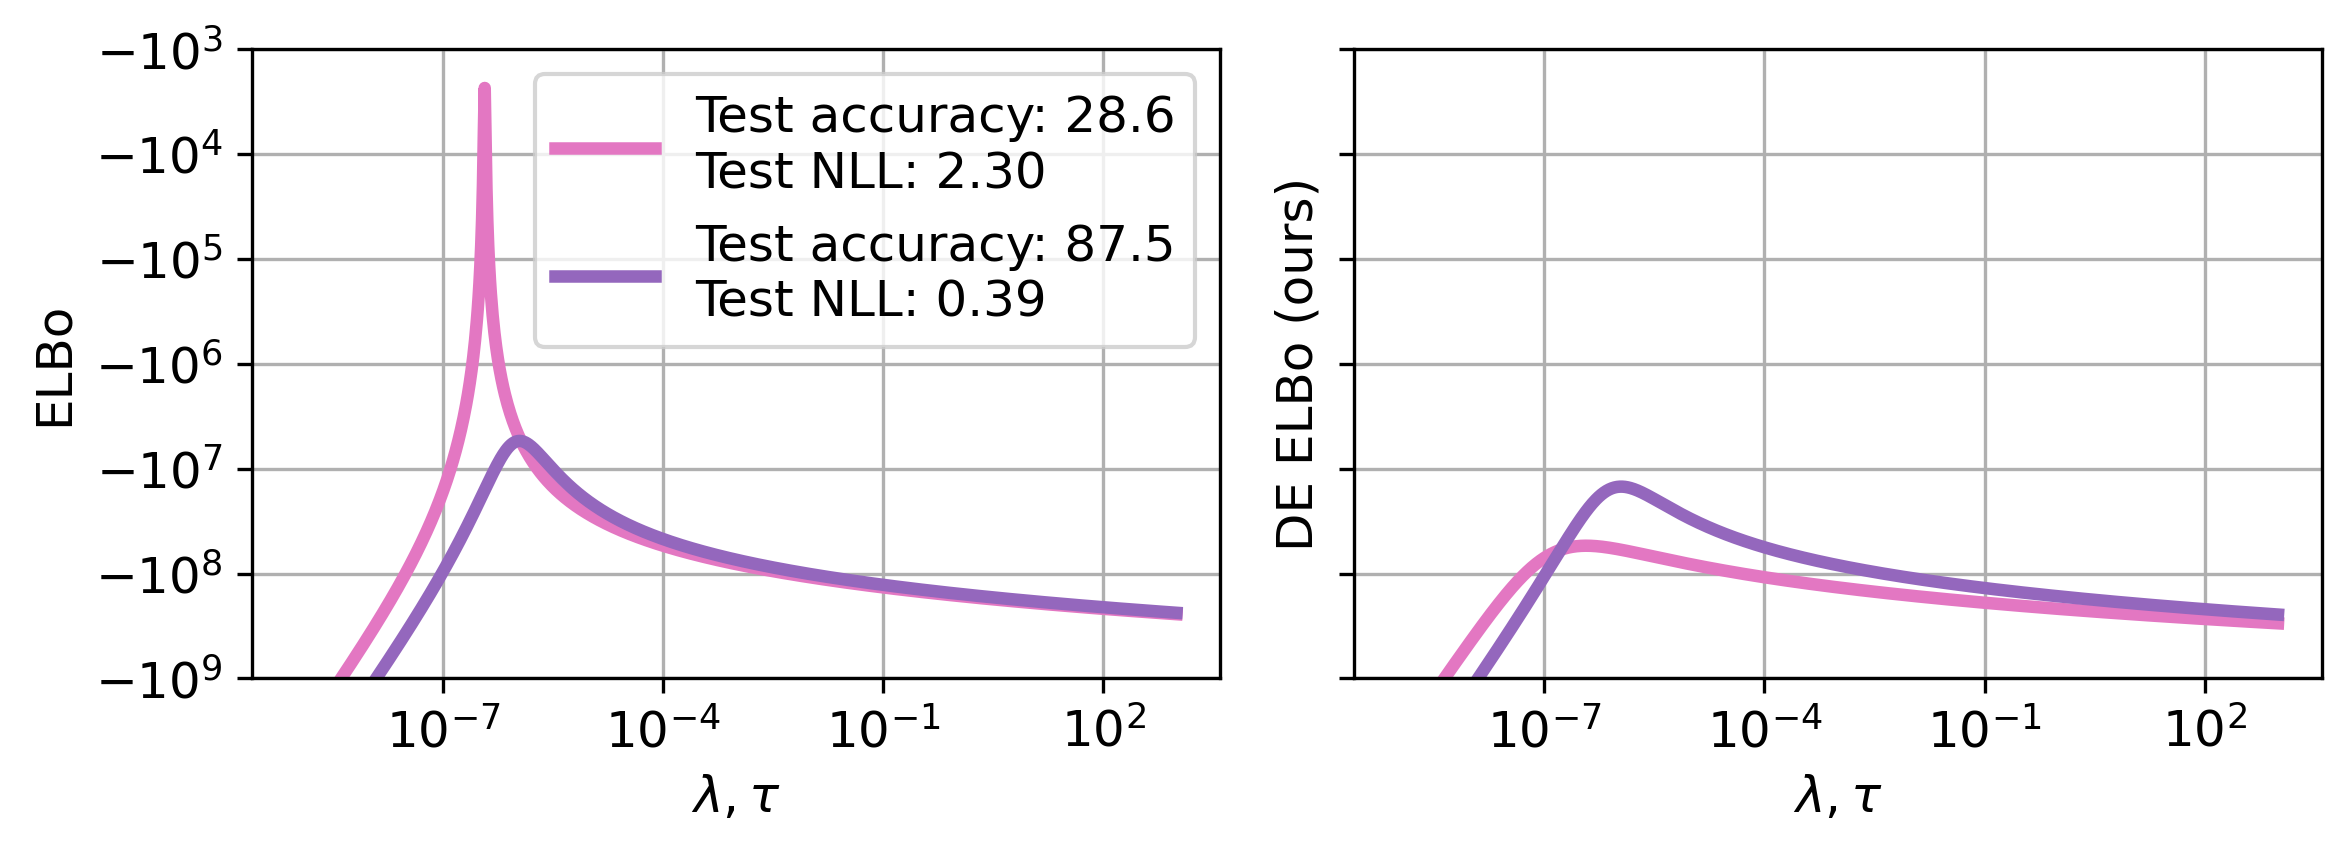

In [7]:
ncols, nrows = 2, 1

fig, axs = plt.subplots(figsize=(4*ncols, 3*nrows), dpi=300, ncols=ncols, nrows=nrows, sharey=True)
axs[0].plot(np.logspace(-9, 3, 1000), -np.array(bad_model_without_kappa), color='#E377C2', label='Test accuracy: 28.6\nTest NLL: 2.30', linewidth=3)
axs[0].plot(np.logspace(-9, 3, 1000), -np.array(good_model_without_kappa), color='#9467BD', label='Test accuracy: 87.5\nTest NLL: 0.39', linewidth=3)
axs[0].set_xscale('log')
axs[0].set_yscale('symlog', linthresh=0.1)
axs[0].set_ylim(-1e9, -1e3)
axs[0].set_xlabel(r'$\lambda, \tau$')
axs[0].set_ylabel('ELBo')
axs[0].legend()
axs[0].grid()
axs[1].plot(np.logspace(-9, 3, 1000), -np.array(bad_model_with_kappa), color='#E377C2', linewidth=3)
axs[1].plot(np.logspace(-9, 3, 1000), -np.array(good_model_with_kappa), color='#9467BD', linewidth=3)
axs[1].set_xscale('log')
axs[1].set_yscale('symlog', linthresh=0.1)
axs[1].set_ylim(-1e9, -1e3)
axs[1].set_xlabel(r'$\lambda, \tau$')
axs[1].set_ylabel(r'DE ELBo (ours)')
axs[1].grid()
fig.tight_layout()
fig.savefig('elbo_comparison.pdf', bbox_inches='tight')
plt.show()